# **Data Exploration and Visualisation**

Every problem requires a set of approaches to tackle it. When finding the approaches, we start with the analysing the data first. From the data, we are able to find out its distribution, relationship between the elements as well as other intricate insights.

This section shows:
1) The distribution of the data
2) The clustering of the elements in terms of their classes
3) Analysis of the relationship between the elements in lower dimensional space


We start with importing all the packages in Python

In [1]:
from torchvision.models.resnet import resnet18, ResNet, BasicBlock
from torchvision.datasets.mnist import MNIST
import numpy as np
import torchvision.transforms as transforms
import torch.utils.data as data
from torch.autograd import Variable

from torchvision.datasets.utils import makedir_exist_ok, download_url
from torch.utils.data import BatchSampler, Dataset, DataLoader
from torchvision import transforms
import zipfile
from PIL import Image
import numpy as np
import umap
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
%matplotlib inline
from sklearn.manifold import TSNE
import seaborn as sns
from gensim.models import Word2Vec
import json
from tqdm import tqdm_notebook as tqdm
import warnings
warnings.filterwarnings("ignore")
import sys,os,io

if 'google.colab' in sys.modules:
    from google.colab import drive
    drive.mount('/content/gdrive')
    file_name = 'DataExploration.ipynb'
    os.chdir('./gdrive/My Drive/Colab Notebooks/CE7454/KAGGLE')
    !pwd



In [2]:
data_dir="./"
os.listdir(data_dir)

train_dataframe = pd.read_csv(data_dir+'train.csv')
testlist = os.listdir(data_dir+'test_images/')
unicode_val=pd.read_csv(data_dir+'unicode_translation.csv').values
unicode_mapping = {codept: char for codept, char in unicode_val}
print("Unicode mapping: ",unicode_mapping)
print("Total number of training pages: ", train_dataframe.shape[0])
print("Total non-valid entries for labels: ",train_dataframe.isnull().sum()['labels'])
print("Total number of testing pages: ", len(testlist))
print(train_dataframe.head())
train_dataframe=train_dataframe.dropna().reset_index()
print("Removed non-valid entries. Now: ",train_dataframe.isnull().sum()['labels'])



Unicode mapping:  {'U+0031': '1', 'U+0032': '2', 'U+0034': '4', 'U+0036': '6', 'U+0039': '9', 'U+003F': '?', 'U+2000B': '𠀋', 'U+20D45': '𠵅', 'U+2123D': '𡈽', 'U+22999': '𢦙', 'U+22CE3': '𢳣', 'U+231C3': '𣇃', 'U+2324A': '𣉊', 'U+233D0': '𣏐', 'U+23D0E': '𣴎', 'U+241C6': '𤇆', 'U+242CE': '𤋎', 'U+2437D': '𤍽', 'U+24E30': '𩹵', 'U+24E60': '𤹠', 'U+24FA3': '𤾣', 'U+2564A': '𩹵', 'U+25750': '𥝐', 'U+25877': '𥡷', 'U+25A0': '■', 'U+25A1': '□', 'U+25B2': '▲', 'U+25B3': '△', 'U+25CB': '○', 'U+25CF': '●', 'U+25DA1': '𥶡', 'U+25E2E': '𥸮', 'U+25EF': '◯', 'U+25FFB': '𥿻', 'U+264B3': '𦒳', 'U+266B0': '𦚰', 'U+27752': '𧝒', 'U+28263': '𩹵', 'U+29780': '𩞀', 'U+29DDA': '𩷚', 'U+29E75': '𩹵', 'U+3002': '。', 'U+3005': '々', 'U+3006': '〆', 'U+3007': '0', 'U+300C': '「', 'U+300D': '」', 'U+3031': '〱', 'U+3032': '〲', 'U+303B': '〻', 'U+303D': '〽', 'U+3042': 'あ', 'U+3044': 'い', 'U+3046': 'う', 'U+3048': 'え', 'U+304A': 'お', 'U+304B': 'か', 'U+304C': 'が', 'U+304D': 'き', 'U+304E': 'ぎ', 'U+304F': 'く', 'U+3050': 'ぐ', 'U+3051': 'け', 'U+3052'

We split the label into each segment and identify by 'U' as unicode in order to extract it out. Then we check if it exist. If it exist we add a count, if otherwise, we create new entry.

In [3]:
chars = {}
for k in range (train_dataframe.shape[0]):
    try:
        #split the label into each segment and identify by 'U' as unicode to extract 
        chararry = [val for val in train_dataframe.labels.values[k].split(' ') if val.startswith('U')]
        num_char = int(len(chararry))        
        for c in chararry:
          #print(c)
          if c not in chars: 
            chars[c]=1
          else:
            chars[c]+=1
        chararry = " ".join(chararry)
    except AttributeError:
        chararry = None
        num_char = 0
        
    train_dataframe.loc[k,'characters'] = chararry
    train_dataframe.loc[k,'num_chars'] = int(num_char)

print(chars)
train_dataframe.head()

{'U+306F': 14759, 'U+304C': 6740, 'U+3044': 11903, 'U+3051': 4224, 'U+306B': 24685, 'U+306E': 24136, 'U+5DE5': 51, 'U+3053': 5665, 'U+4E09': 1371, 'U+3084': 6141, 'U+3068': 16588, 'U+5DF1': 106, 'U+3082': 12325, 'U+3055': 7089, 'U+4E16': 705, 'U+7D30': 188, 'U+305D': 3742, 'U+4EBA': 2511, 'U+308C': 7144, 'U+3060': 3161, 'U+5F37': 231, 'U+305F': 9973, 'U+3066': 20569, 'U+4FF3': 28, 'U+6839': 295, 'U+304B': 14342, 'U+8AE7': 25, 'U+5B50': 1838, 'U+3092': 15743, 'U+53CA': 306, 'U+8005': 470, 'U+305A': 2060, 'U+907F': 13, 'U+6B63': 170, 'U+6587': 298, 'U+3075': 7076, 'U+6642': 1095, 'U+601D': 757, 'U+306A': 13750, 'U+3081': 3190, 'U+6D6E': 101, 'U+6C17': 795, 'U+8077': 21, 'U+8001': 207, 'U+6B66': 213, 'U+697D': 110, 'U+76F2': 29, 'U+82E5': 216, 'U+81EA': 262, 'U+3069': 3005, 'U+98A8': 592, 'U+88CF': 92, 'U+7573': 32, 'U+606F': 80, 'U+5E8F': 26, 'U+3057': 22209, 'U+3078': 8168, 'U+306C': 1810, 'U+5FC3': 963, 'U+3064': 7052, 'U+3093': 6994, 'U+308B': 11617, 'U+3072': 4414, 'U+3089': 10089, '

,index,image_id,labels,characters,num_chars
0,0,100241706_00004_2,U+306F 1231 3465 133 53 U+304C 275 1652 84 69 ...,U+306F U+304C U+3044 U+3051 U+306B U+306B U+30...,67.0
1,1,100241706_00005_1,U+306F 1087 2018 103 65 U+304B 1456 1832 40 73...,U+306F U+304B U+304B U+3044 U+306B U+306B U+30...,80.0
2,2,100241706_00005_2,U+306F 572 1376 125 57 U+306E 1551 2080 69 68 ...,U+306F U+306E U+3078 U+304C U+306B U+3081 U+30...,78.0
3,3,100241706_00006_1,U+3082 1455 3009 65 44 U+516B 1654 1528 141 75...,U+3082 U+516B U+309E U+306B U+308B U+304B U+30...,72.0
4,4,100241706_00007_2,U+309D 1201 2949 27 33 U+309D 1196 1539 27 36 ...,U+309D U+309D U+309D U+309D U+3078 U+309D U+25...,167.0


The following section explore the distribution of the dataset. The dataset is found to be very imbalanced. The dominant characters are appearing in huge quantity and we may need to address the issue of imbalanced dataset.

In [4]:
csv_info = pd.DataFrame(list(chars.items()), columns=['char', 'count'])
csv_info['japanesechar'] = csv_info['char'].map(unicode_mapping)
print ("Occurence of most frequent characters:")
print ("Total different type of characters: ",csv_info.shape[0])
csv_info.to_csv(data_dir+"chars_freq.csv")
csv_info_sorted=csv_info.sort_values("count", ascending=False)
csv_info_sorted.head()

Occurence of most frequent characters:
Total different type of characters:  4212


,char,count,japanesechar
4,U+306B,24685,に
5,U+306E,24136,の
55,U+3057,22209,し
22,U+3066,20569,て
10,U+3068,16588,と


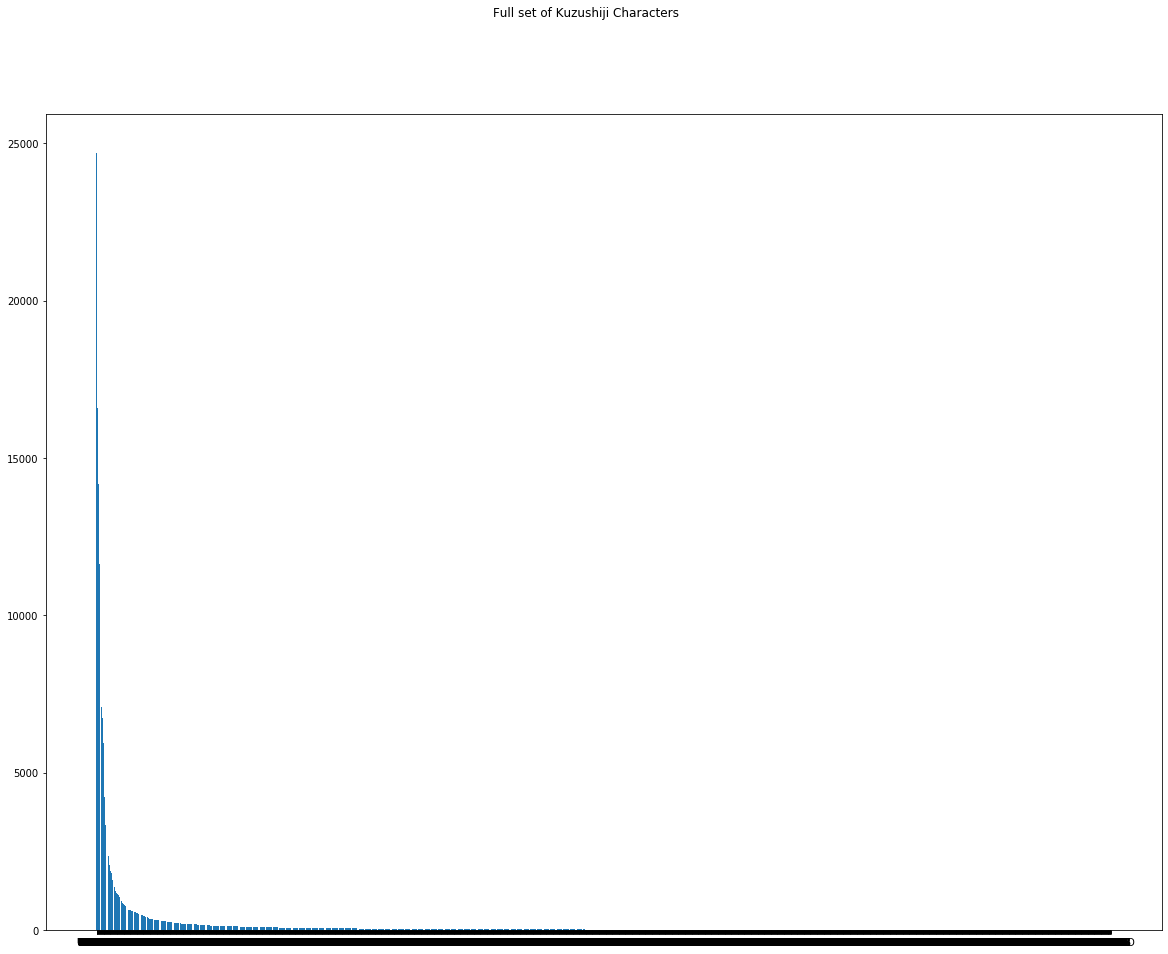

In [5]:
fig = plt.figure(figsize=(20, 15))
fig.suptitle("Full set of Kuzushiji Characters")
t=plt.bar(csv_info_sorted['char'],csv_info_sorted['count'])
#t=sns.barplot(y="char",x="count",data=csv_info_sorted,color='orange').set_title("Full set of Kuzushiji Characters")

In [6]:
# Calculate 50% most dominant characters
totalcharscnt=csv_info_sorted['count'].sum()
print("Total number of characters in the dataset: ", totalcharscnt)
dom50=0.5*totalcharscnt

def domindex(df,dom):
  cnt=0
  for i in range(df['char'].count()):
    cnt+=df.iloc[i,1]
    if cnt>dom:
      ind=i
      break
  return ind
ind50=domindex(csv_info_sorted,dom50)
print("Total number for 50% most dominant characters: ", ind50)


Total number of characters in the dataset:  683464
Total number for 50% most dominant characters:  29


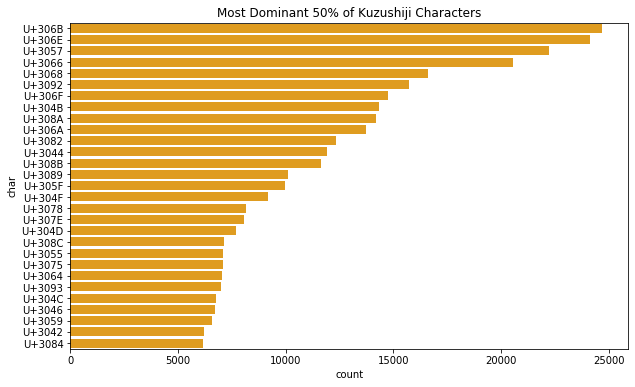

In [7]:
# plot 50% most dominant characters
fig = plt.figure(figsize=(10, 6))
t=sns.barplot(y="char",x="count",data=csv_info_sorted.head(ind50),color='orange').set_title("Most Dominant 50% of Kuzushiji Characters")

Total number for 80% most dominant characters:  201


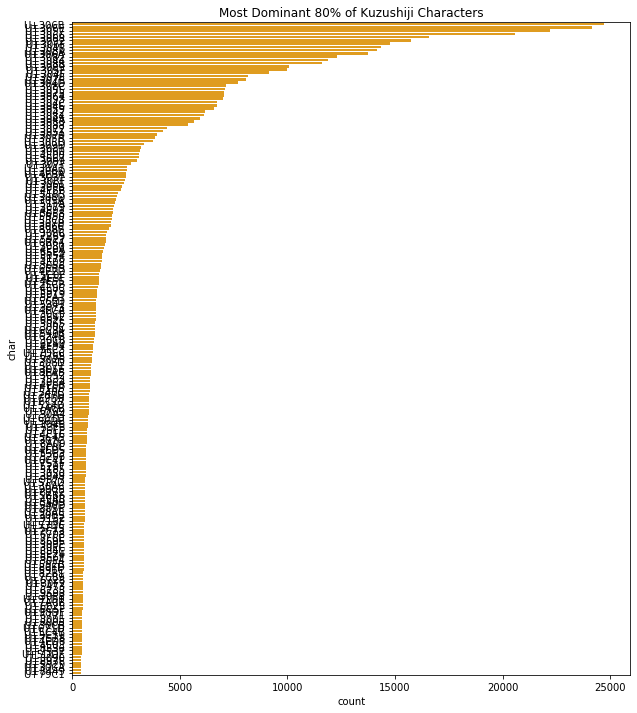

In [8]:
# Calculate 80% most dominant characters
dom80=0.8*totalcharscnt
ind=domindex(csv_info_sorted,dom80)
print("Total number for 80% most dominant characters: ", ind)
# plot 80% most dominant characters
fig = plt.figure(figsize=(10, 12))
t=sns.barplot(y="char",x="count",data=csv_info_sorted.head(ind),color='orange').set_title("Most Dominant 80% of Kuzushiji Characters")

The following shows that 925 characters covers 95% of the entire dataset. It shows that about 3/4 of the characters appear infrequently.

Total number for 95% most dominant characters:  925


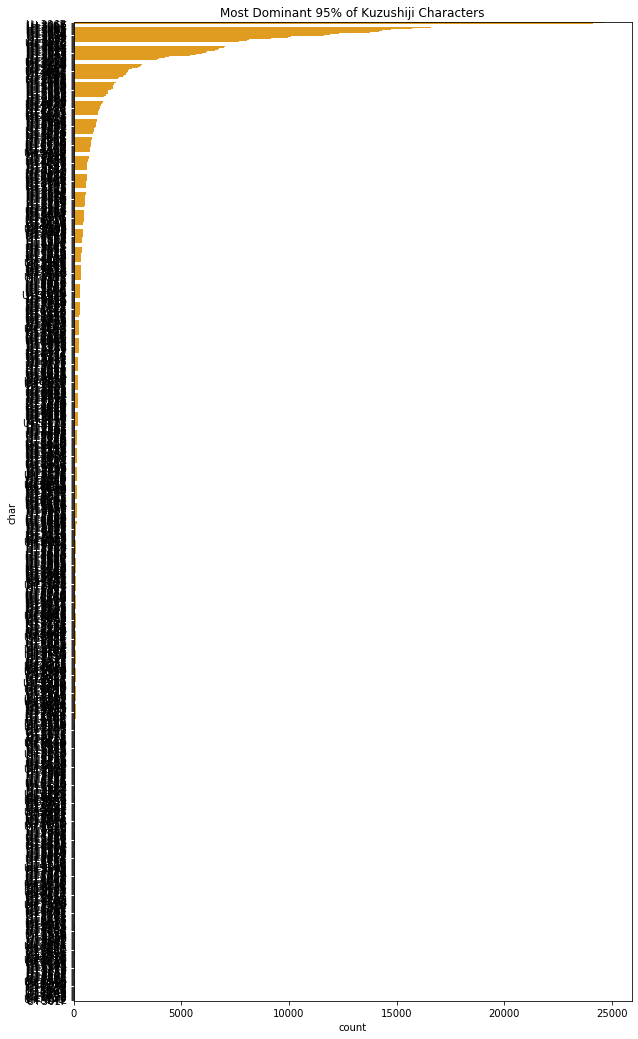

In [9]:
# Calculate 95% most dominant characters
dom=0.95*totalcharscnt
ind=domindex(csv_info_sorted,dom)
print("Total number for 95% most dominant characters: ", ind)
# plot 95% most dominant characters
fig = plt.figure(figsize=(10, 18))
t=sns.barplot(y="char",x="count",data=csv_info_sorted.head(ind),color='orange').set_title("Most Dominant 95% of Kuzushiji Characters")

In [10]:
# list of characters that appear in top 50% of the dataset
print(csv_info_sorted.head(ind50))
domx50=np.array(csv_info_sorted.head(ind50)['char'])
print(domx50)

       char  count japanesechar
4    U+306B  24685            に
5    U+306E  24136            の
55   U+3057  22209            し
22   U+3066  20569            て
10   U+3068  16588            と
28   U+3092  15743            を
0    U+306F  14759            は
25   U+304B  14342            か
70   U+308A  14184            り
38   U+306A  13750            な
12   U+3082  12325            も
2    U+3044  11903            い
61   U+308B  11617            る
63   U+3089  10089            ら
21   U+305F   9973            た
64   U+304F   9167            く
56   U+3078   8168            へ
111  U+307E   8075            ま
128  U+304D   7686            き
18   U+308C   7144            れ
13   U+3055   7089            さ
35   U+3075   7076            ふ
59   U+3064   7052            つ
60   U+3093   6994            ん
1    U+304C   6740            が
204  U+3046   6725            う
157  U+3059   6592            す
88   U+3042   6185            あ
9    U+3084   6141            や
['U+306B' 'U+306E' 'U+3057' 'U+3066' 'U+

The training set contains bounding boxes and labels for each page. We can extract the image for each characters and save it as an individual image of a character. These images are used for the visualisation of clustering using TSNE, UMAP. The following code uses the bounding boxes provided in the train.csv and the image is cropped out of the original page and save as each character. As part of the study in this project, we also used this set of character images to train the classifier using the RESNET30. Some of the attempts such as class weighting, stages training and data augmentation methods were investigated.
 

In [11]:
def get_char(img_id, labels):
    image_fn = data_dir+"train_images/{}.jpg".format(img_id)
    # Convert annotation string to array
    labels = np.array(labels.split(' ')).reshape(-1, 5)
    # Read image
    imsource = Image.open(image_fn).convert('RGBA')
    img = np.asarray(imsource.convert("RGB"))

    info = []
    
    for idx, (codept, x, y, w, h) in enumerate(labels):
        x, y, w, h = int(x), int(y), int(w), int(h)
        try:
            char = unicode_mapping[codept] 
        except KeyError:
            char = "_" 
        #Crop out the character from the original image by using bounding box
        crop_img = img[y:y+h, x:x+w]
        result = Image.fromarray(crop_img, mode='RGB')
        name = img_id+'_{}.jpg'.format(idx)
        result.save(data_dir+'kmnist/images/'+name)
        info.append((name,codept))
    del imsource, img, result, name
    return info
if not(os.path.exists(data_dir+"info_csv.csv")):
    print("Attempt to create set of images of characters")
    info = []
    for i in train_dataframe.index:
        img, labels,_,_ = train_dataframe.values[i]
        info += get_char(img, labels)
    info_csv=pd.DataFrame(info,columns=["imagename", "char"])
    info_csv.to_csv(data_dir+"info_csv.csv")
else:
    print("Image directory already existed")


Image directory already existed


A Dataset loader is created to facilitate the retrieval of the particular unicode character with its corresponding image in array. The loader is also used in the study of classification. To visualise the clustering of the characters, we uses random sampling from the pool of 683464 characters. We analyse the 50% most dominant characters as well as top-10 dominant characters that appear in the dataset.

In [12]:
class kuzu_dataset(Dataset):
  def __init__(self, csv,  diry, labeldict, transform=None):
    self.diry=diry
    self.csv=pd.read_csv(csv)
    self.transform = transform
    self.labeldict=labeldict

  def __len__(self):
    return len(self.csv)
  
  def __getitem__(self,ind):
    filename=self.csv.iloc[ind,1]
    label=self.csv.iloc[ind,2]
    img=Image.open(self.diry+filename)
    imgnp=np.asarray(img)
    imgnp_re=cv2.resize(imgnp[:,:,1],(28,28),interpolation = cv2.INTER_CUBIC)
    img=Image.fromarray(imgnp_re)
    labelidx=np.asarray(self.labeldict[label])
    onehot=np.zeros(4212)
    onehot[labelidx]=1.0
    sample={'image':imgnp_re,'label':onehot,'char':label}
    if self.transform:
      sample=self.transform(sample)
    return sample


In [13]:
charfreq=pd.read_csv(data_dir+"chars_freq.csv")
labeldict=dict()
for i in range(charfreq['char'].count()):
  labeldict.update({charfreq['char'][i]:i})
ds=kuzu_dataset(data_dir+"info_csv.csv",data_dir+"kmnist/images/", labeldict)

In [14]:
infocsv=pd.read_csv(data_dir+"info_csv.csv")
imgsize=28*28
charcnt=len(domx50)
samplesize=1000
images = np.zeros(shape=(charcnt * samplesize, imgsize), dtype=np.uint8)
labels = np.zeros(shape=(charcnt * samplesize,), dtype=np.uint16)
cnt=0
ulabel=np.zeros(shape=(charcnt,), dtype=np.uint16)

for char in domx50:
  ind=np.where(infocsv['char']==char)
  indrand=np.random.choice(ind[0],samplesize,replace=False)
  for i in range(samplesize):
      datads=ds.__getitem__(indrand[i])
      img=datads['image'].flatten()
      label=id(datads['char'])
      images[cnt*samplesize+i]=img
      labels[cnt*samplesize+i]=label
  ulabel[cnt]=label
  cnt=cnt+1



The embeddings from the 29 dominant Kuzushiji characters which are about 50% of the whole dataset, are shown below using the TSNE (T-distributed Stochastic Neighbor Embedding) plot. The TSNE technique is a nonlinear reduction of higher dimensional data to a much lower dimension e.g. 2-dimension. The TSNE plot provides a view of the proximity between the embeddings. The closer proximity indicates better similarity in terms of features. We can see that some characters like U+306A and U+3057 have big distance between the embeddings, indicating that the characters may perhaps have a bigger variation in style. Some of the clusters of same characters (e.g. U+306B) are separated into few groups. This indicates that there may be different way of writing the same character in a different context.

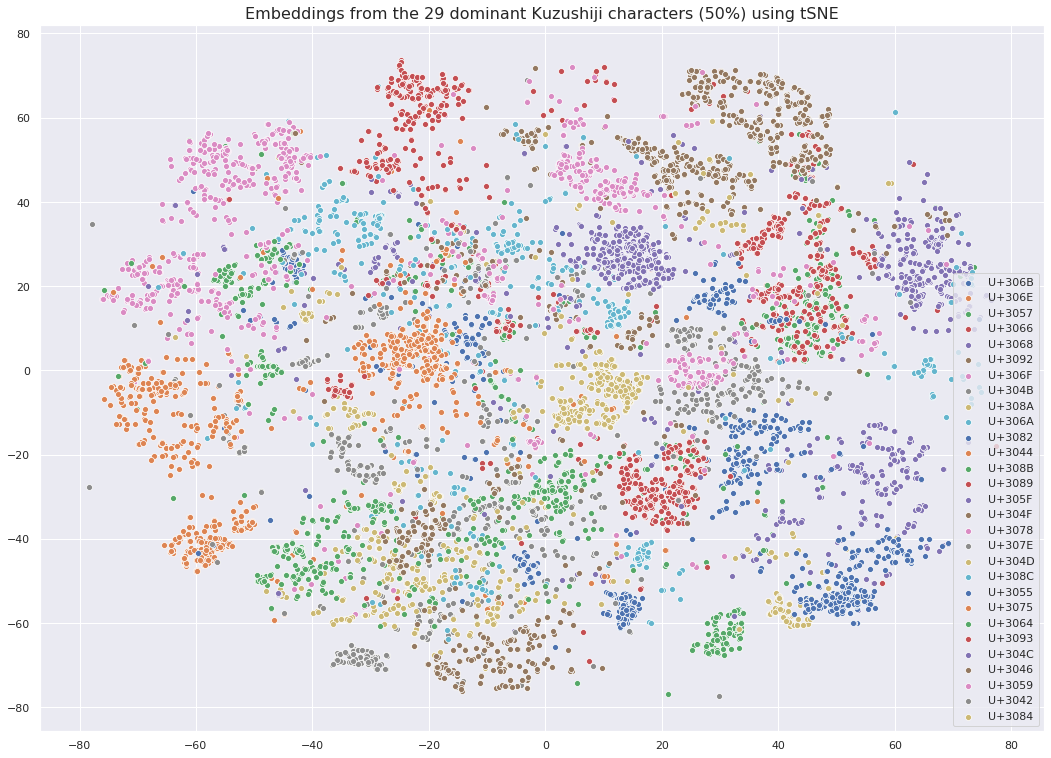

In [15]:
sns.set()
tsne = TSNE(n_components=2, perplexity=10)
tsne_2d = tsne.fit_transform(images)
fig = plt.figure(figsize=(18, 13))
for i in ulabel:
    sns.scatterplot(tsne_2d[labels == i, 0],tsne_2d[labels == i, 1], label=i, alpha=1.0)
plt.title("Embeddings from the 29 dominant Kuzushiji characters (50%) using tSNE", fontsize=16)
plt.legend(domx50)
plt.show()


The following is an analysis using the top-10 most dominant characters in the dataset. For characters U+306A and U+3057, it still shows that it has a variation and the embeddings are distributed. Same observation for U+306B, the clusters are separated.

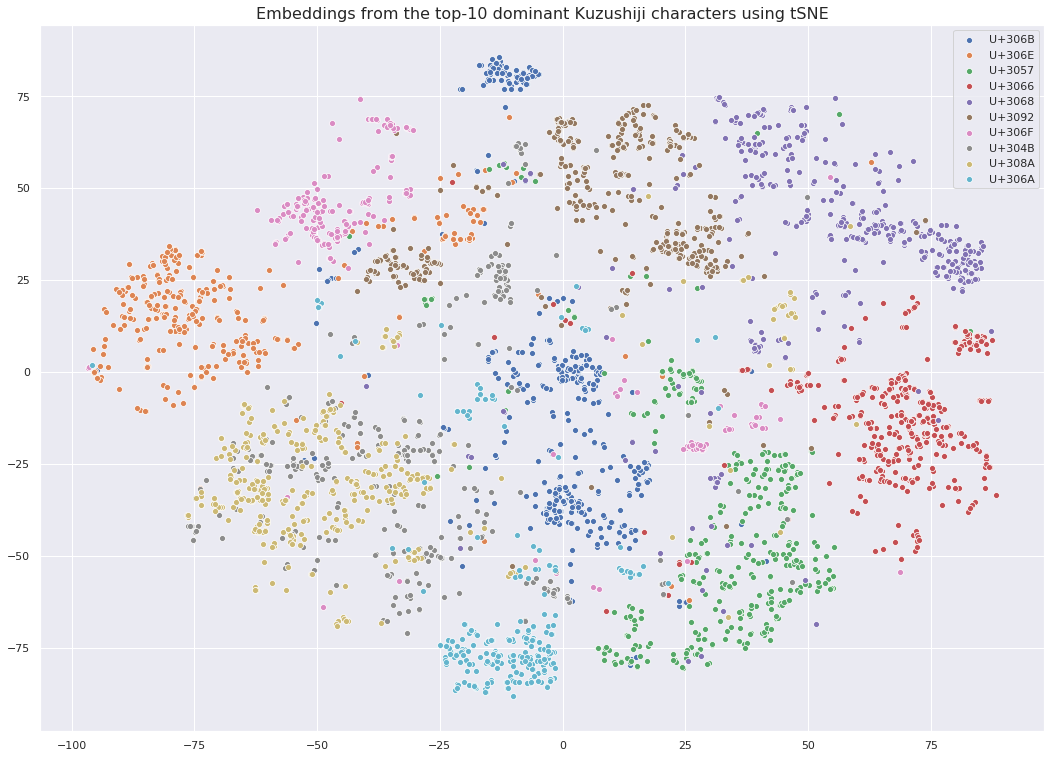

In [16]:
domx10=domx50[0:10]
charcnt=len(domx10)
samplesize=1000
images = np.zeros(shape=(charcnt * samplesize, imgsize), dtype=np.uint8)
labels = np.zeros(shape=(charcnt * samplesize,), dtype=np.uint16)
cnt=0
ulabel=np.zeros(shape=(charcnt,), dtype=np.uint16)

for char in domx10:
  ind=np.where(infocsv['char']==char)
  indrand=np.random.choice(ind[0],samplesize,replace=False)
  for i in range(samplesize):
      datads=ds.__getitem__(indrand[i])
      img=datads['image'].flatten()
      label=id(datads['char'])
      images[cnt*samplesize+i]=img
      labels[cnt*samplesize+i]=label
  ulabel[cnt]=label
  cnt=cnt+1
sns.set()
tsne = TSNE(n_components=2, perplexity=10)
tsne_2d = tsne.fit_transform(images)
fig = plt.figure(figsize=(18, 13))
for i in ulabel:
    sns.scatterplot(tsne_2d[labels == i, 0],tsne_2d[labels == i, 1], label=i, alpha=1.0)
plt.title("Embeddings from the top-10 dominant Kuzushiji characters using tSNE", fontsize=16)
plt.legend(domx10)
plt.show()

The UMAP (Uniform Manifold Approximation) has a better view of the clustering for the characters. It is also a dimension reduction technique. It works well when the manifold is locally connected. Clearly, the characters U+3066 and U+3057 are spreaded and indicated that they have bigger variation.

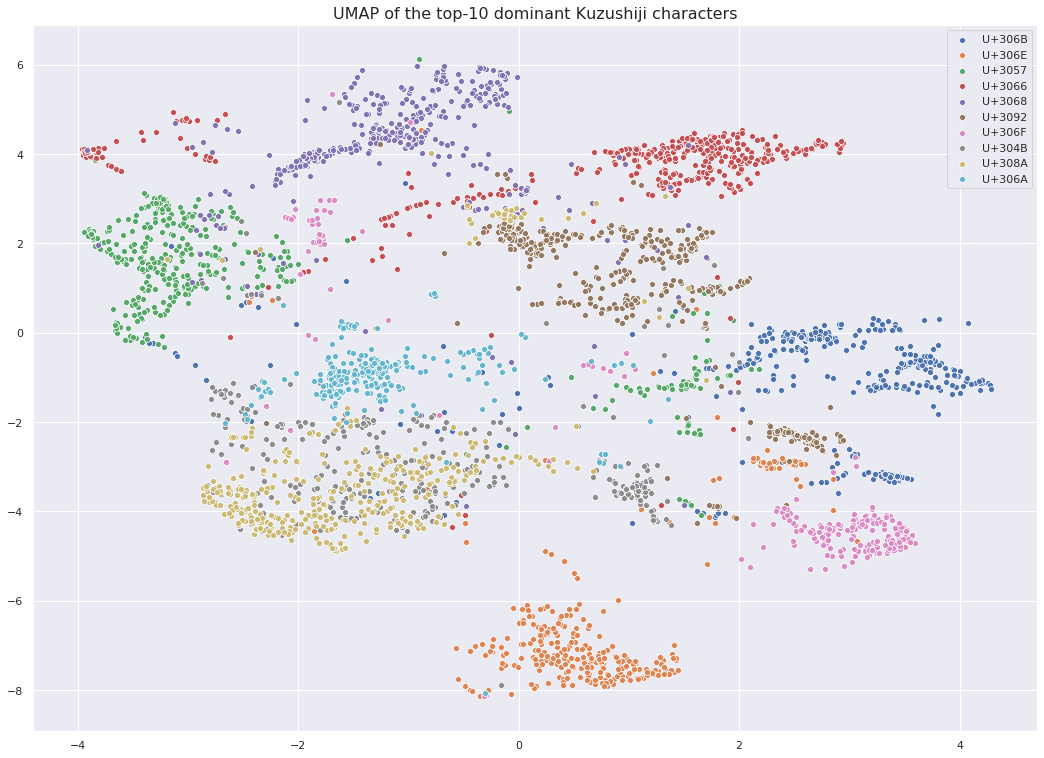

In [17]:
uMap = umap.UMAP()
umap_embed = uMap.fit_transform(images)
fig = plt.figure(figsize=(18, 13))
for i in ulabel:
    sns.scatterplot(umap_embed[labels == i, 0],umap_embed[labels == i, 1],label=i, alpha=1.0)
plt.title("UMAP of the top-10 dominant Kuzushiji characters", fontsize=16)
plt.legend(domx10)
plt.show()

Apart from the similarity of characters for the manifold. We also visualise the relationship of characters in sequences as bag of words. We extracted the sequences from the documents by ordering the characters from right to left, up to down as the way how the japanese characters are read by a human. We uses gensim to create a model from the sequences. By using TSNE we further reduce the dimension of the embeddings from the model to 2. The scatter plot shows some characters are clustered closer to each other indicating their relationship in a sequence. We also find that the most dominant characters are more closely clustered together as well.

In [18]:
allwords=[]
seq_dir=data_dir+"train_jsons_dbscan/"
for file in os.listdir(seq_dir):
  with open(seq_dir+file, "r") as read_file:
      data = json.load(read_file)
      allwords.append(data['all_elems'])

In [19]:
model = Word2Vec(allwords, min_count=20,size= 25,workers=12, window =30, sg = 1,iter=1000)

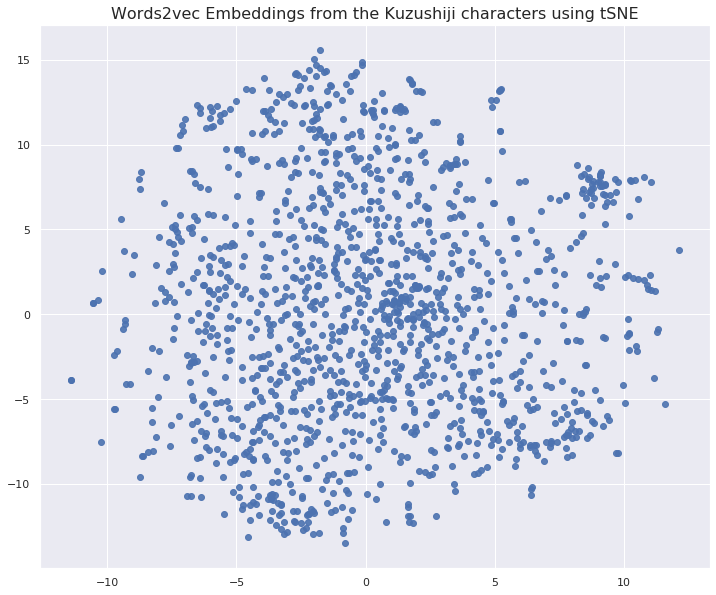

In [24]:
vocab=model.wv.vocab
ulabel=list(vocab.keys())
tsne_data=model.wv[vocab]
tsne=TSNE(n_components=2,perplexity=100)
tsne_vec=tsne.fit_transform(tsne_data)
fig = plt.figure(figsize=(12, 10))
plt.scatter(tsne_vec[:, 0], tsne_vec[:, 1], alpha=0.9)    
plt.title("Words2vec Embeddings from the Kuzushiji characters using tSNE", fontsize=16)
#plt.legend("Chars")
plt.show()


In [21]:
print("Most similar to U306B:")
print(model.most_similar('U+306B'))
print("Most similar to U304C:" )
print(model.most_similar('U+304C'))
print("Similaity measure between U+308D and U+3046 :", model.similarity('U+308D','U+3046'))
print("Similaity measure between U+3072 and U+3046 :", model.similarity('U+3072','U+3046'))

Most similar to U306B:
[('U+3066', 0.978304386138916), ('U+3068', 0.9735230207443237), ('U+308A', 0.9544915556907654), ('U+3075', 0.953606128692627), ('U+3092', 0.9534550309181213), ('U+3072', 0.9525570869445801), ('U+308B', 0.9409906268119812), ('U+3042', 0.9383695125579834), ('U+3057', 0.93660968542099), ('U+306F', 0.931887686252594)]
Most similar to U304C:
[('U+3089', 0.9770174026489258), ('U+304A', 0.9695980548858643), ('U+305D', 0.9691889882087708), ('U+3067', 0.9625091552734375), ('U+3060', 0.9599828124046326), ('U+3055', 0.9579623937606812), ('U+3084', 0.957256555557251), ('U+305F', 0.9566665291786194), ('U+304B', 0.9527163505554199), ('U+3078', 0.9486269950866699)]
Similaity measure between U+308D and U+3046 : 0.94658697
Similaity measure between U+3072 and U+3046 : 0.9191998
